In [1]:
from torch.utils.data import Dataset, random_split, DataLoader
from glob import glob
from PIL import Image

# downloading data from the cloud

In [2]:
import gdown, os, shutil
def download_from_cloud(url, ds_name, root, temp_name = "temp_file.zip"):
    os.makedirs(root, exist_ok=True)
    d_url = f"https://drive.google.com/uc?id={url.split('/')[-2]}"

    if os.path.exists(f"{root}/{ds_name}"): print(f"{ds_name} nomli data allaqachon yuklab olingan")
    else:
        print(f"Fayl {temp_name} nomi bilan yuklanmoqda...")
        gdown.download(d_url, temp_name, quiet= False)
        print(f"{temp_name} fayli muvaffaqiyatli yuklab olindi!")
        shutil.unpack_archive(f"{temp_name}", f"{root}")
        print("Fayl arxivdan ochilmoqda")
        os.remove(f"{temp_name}")
        print(f"Tanlangan dataset {root} papkasiga yuklab olindi!")
    path = f"{root}/{ds_name}"
    return path


In [3]:
url = "https://drive.google.com/file/d/1300TOXjFlJ370l0kaN63f7vsbO5jyjBf/view"

In [4]:
path = download_from_cloud(url, ds_name = "ants_bees", root = "ants&bees_ds")

Fayl temp_file.zip nomi bilan yuklanmoqda...


Downloading...
From (original): https://drive.google.com/uc?id=1300TOXjFlJ370l0kaN63f7vsbO5jyjBf
From (redirected): https://drive.google.com/uc?id=1300TOXjFlJ370l0kaN63f7vsbO5jyjBf&confirm=t&uuid=d78aa1d4-d6ae-4940-8206-5c2b68246f8f
To: /content/temp_file.zip
100%|██████████| 47.3M/47.3M [00:01<00:00, 24.6MB/s]


temp_file.zip fayli muvaffaqiyatli yuklab olindi!
Fayl arxivdan ochilmoqda
Tanlangan dataset ants&bees_ds papkasiga yuklab olindi!


# importing data from a local disk

In [5]:
from torchvision import transforms as T
pic_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
tfs=T.Compose([T.ToTensor(), T.Resize((pic_size, pic_size)), T.Normalize(mean = mean, std = std)])


In [6]:
class Downloadit(Dataset):
    def __init__(self, path, data_type, pic_type = [".jpg", ".png", ".bmp"], transformations = None):
        super().__init__()
        self.pic_path = glob(f"{path}/{data_type}/*/*{[t for t in pic_type]}")
        self.transformations = transformations


    def __len__(self): return len(self.pic_path)




    def klasni_aniqlash(self, pic_path_1):
        javob = 1 if 'bees' == (os.path.basename(os.path.dirname(pic_path_1))) else 0
        return javob
    def __getitem__(self, idx):
        pic_path_1 = self.pic_path[idx]

        pic = Image.open(pic_path_1).convert("RGB")
        gt  = self.klasni_aniqlash(pic_path_1)
        if self.transformations: pic = self.transformations(pic)
        return pic, gt

    def len_of_dataset(self):
        data = self.pic_path
        return len(data)

In [7]:
train = Downloadit(path = path, data_type = "train",  transformations = tfs)
test  = Downloadit(path = path, data_type = "val", transformations = tfs)

# Splitting the data and creating dataloader

In [8]:
from torch.utils.data import DataLoader, random_split
val_size   = len(train) - int(len(train)*0.9)
train_size = len(train) - val_size

train_ds, val_ds = random_split(dataset = train, lengths = [train_size, val_size])
bs = 8

test_dl  = DataLoader(dataset = test, batch_size = 1, shuffle = False, num_workers = 2)
train_dl = DataLoader(dataset = train_ds, batch_size = bs, shuffle = True, num_workers = 2)
val_dl   = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 2)

# Creating custom (CNN) model

In [9]:
import torch
device = "cuda" if torch.cuda.is_available()==True else "cpu"

from torch.nn import *
class conv_model(Module):
    def __init__(self, in_ch, out_ch, ks, n_cls):
        super().__init__()
        self.conv_1 = Conv2d(in_channels = in_ch, out_channels = out_ch, kernel_size = ks, padding = 0, stride = 1)
        self.bn_1   = BatchNorm2d(num_features = out_ch)


        self.conv_2 = Conv2d(in_channels = out_ch, out_channels = out_ch*2, kernel_size = ks)
        self.bn_2   = BatchNorm2d(num_features = out_ch*2)

        self.conv_3 = Conv2d(in_channels = out_ch*2, out_channels = out_ch*4, kernel_size = ks)
        self.bn_3   = BatchNorm2d(num_features = out_ch*4)

        self.conv_4 = Conv2d(in_channels = out_ch*4, out_channels = out_ch*8, kernel_size = ks)
        self.bn_4   = BatchNorm2d(num_features = out_ch*8)

        self.conv_5 = Conv2d(in_channels = out_ch*8, out_channels = out_ch*16, kernel_size = ks)
        self.bn_5   = BatchNorm2d(num_features = out_ch*16)

        self.conv_6 = Conv2d(in_channels = out_ch*16, out_channels = out_ch*32, kernel_size = ks)
        self.bn_6   = BatchNorm2d(num_features = out_ch*32)

        self.f_conv = Conv2d(in_channels = out_ch*32, out_channels = n_cls, kernel_size = 1)

        self.dr     = Dropout(p = 0.3)
        self.mp     = MaxPool2d(kernel_size = 2, stride = 2)
        self.relu   = ReLU()
        self.softmax= Softmax(dim = 1)
    def forward(self, data):

        out_1 = self.conv_1(data)
        out_1 = self.relu(out_1)
        out_1 = self.bn_1(out_1)
        out_1 = self.dr(out_1)
        out_1 = self.mp(out_1)
        #print(out_1.shape)
        out_2 = self.conv_2(out_1)
        out_2 = self.relu(out_2)
        out_2 = self.bn_2(out_2)
        out_2 = self.dr(out_2)
        out_2 = self.mp(out_2)
        #print(out_2.shape)
        out_3 = self.conv_3(out_2)
        out_3 = self.relu(out_3)
        out_3 = self.bn_3(out_3)
        out_3 = self.dr(out_3)
        out_3 = self.mp(out_3)
        #print(out_3.shape)
        out_4 = self.conv_4(out_3)
        out_4 = self.relu(out_4)
        out_4 = self.bn_4(out_4)
        out_4 = self.dr(out_4)
        out_4 = self.mp(out_4)
        #print(out_4.shape)
        out_5 = self.conv_5(out_4)
        out_5 = self.relu(out_5)
        out_5 = self.bn_5(out_5)
        out_5 = self.dr(out_5)
        out_5 = self.mp(out_5)
        #print(out_5.shape)
        out_6 = self.conv_6(out_5)
        out_6 = self.relu(out_6)
        out_6 = self.bn_6(out_6)
        out_6 = self.dr(out_6)
        out_6 = self.mp(out_6)
        #print(out_6.shape)
        f_out = self.f_conv(out_6)
        f_out = self.softmax(f_out).squeeze(2).squeeze(2)
        return f_out

inp = torch.rand(1, 3, 224, 224)
model = conv_model(in_ch = inp.shape[1], out_ch = 8, ks = 3, n_cls = 2)
model.to(device)

# training loop using pre-trained models

In [33]:
import time
import os
from tqdm import tqdm
import torch



def model_train(train_dl, model, loss_fn, opt, device):
  epoc_loss, train_acc = 0, 0
  model.to(device)
  model.train()
  for idx, batch in enumerate(tqdm(train_dl, desc = "Train jarayoni...")):
    pics, gts = batch
    pics, gts = pics.to(device), gts.to(device)
    preds = resnet(pics)
    t_loss = loss_fn(preds, gts)

    opt.zero_grad()
    t_loss.backward()
    opt.step()
        #accuracy
    javoblar = torch.argmax(preds, dim=1)
    acc = (torch.sum(javoblar == gts).item()/len(gts))*100
    train_acc += acc/len(train_dl)
    epoc_loss += t_loss/len(train_dl)
  return epoc_loss, train_acc

def model_val(val_dl, model, loss_fn, device, ):
  epoc_loss, val_acc_2 = 0, 0
  model.to(device)

  model.eval()
  with torch.no_grad():
      for idx, batch in enumerate(tqdm(val_dl, desc="Validation jarayoni...")):
          pics, gts = batch
          pics, gts = pics.to(device), gts.to(device)
          preds = resnet(pics)
          v_loss = loss_fn(preds, gts).item()
          epoc_loss += v_loss/len(val_dl)
          #accuracy
          javoblar_1 = torch.argmax(preds, dim=1)
          acc_2 = ((torch.sum(javoblar_1 == gts ).item()/len(gts))*100)/len(val_dl)
          val_acc_2 += acc_2
  return epoc_loss, val_acc_2

def do_train(train_dl, val_dl, model, loss_fn, opt, device, epochs, patience, model_dir = "best_model_dir"):
  os.makedirs(model_dir, exist_ok=True)
  best_acc = 0
  patience_counter = 0
  start_time = time.time()
  for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = model_train(train_dl, model, loss_fn, opt, device)
    val_loss, val_acc = model_val(val_dl, model, loss_fn, device)
    if val_acc > best_acc:
      best_acc = val_acc
      patience_counter = 0
      torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pt"))
      print()

    else: patience_counter += 1
    if patience_counter == patience:
      print(f"{best_acc:.2f}% accuracyga erishgan eng yaxshi model saqlandi.")
      print(f"AI model accuracy si so'nggi {patience} epoc davomida ko'tarilmagani uchun train jarayoni yakullandi ")
      break
    print(f"Train Loss -> {train_loss:.4f}    | Train Accuracy -> {train_acc:.2f}%")
    print(f"Val Loss   ->   {val_loss:.4f}  | Val Accuracy   ->   {val_acc:.2f}%")
  end_time = time.time()
  print(f"\nTraining completed in {(end_time - start_time):.2f} seconds.")
  print(f"Best Validation Accuracy: {best_acc:.2f}%")

In [34]:
import timm
import time
import torch
resnet = timm.create_model(model_name = "resnet18", pretrained = True, num_classes = 2)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = resnet.parameters(), lr = 0.001)

do_train(train_dl = train_dl, val_dl =val_dl, model = resnet, loss_fn = loss_fn, opt = opt, device = device, epochs = 100 , patience = 10)


Epoch 1/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.78it/s]



Train Loss -> 0.5224    | Train Accuracy -> 77.38%
Val Loss   ->   0.3211  | Val Accuracy   ->   81.25%

Epoch 2/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.48it/s]



Train Loss -> 0.2870    | Train Accuracy -> 88.69%
Val Loss   ->   0.2467  | Val Accuracy   ->   84.38%

Epoch 3/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 14.17it/s]



Train Loss -> 0.2058    | Train Accuracy -> 93.75%
Val Loss   ->   0.2029  | Val Accuracy   ->   93.75%

Epoch 4/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Train Loss -> 0.1739    | Train Accuracy -> 93.30%
Val Loss   ->   0.7235  | Val Accuracy   ->   59.38%

Epoch 5/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


Train Loss -> 0.1377    | Train Accuracy -> 95.09%
Val Loss   ->   0.1439  | Val Accuracy   ->   93.75%

Epoch 6/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Train Loss -> 0.1279    | Train Accuracy -> 95.54%
Val Loss   ->   0.1691  | Val Accuracy   ->   93.75%

Epoch 7/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s]


Train Loss -> 0.1269    | Train Accuracy -> 96.87%
Val Loss   ->   0.3636  | Val Accuracy   ->   65.62%

Epoch 8/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Train Loss -> 0.0875    | Train Accuracy -> 98.21%
Val Loss   ->   0.1763  | Val Accuracy   ->   93.75%

Epoch 9/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 14.00it/s]


Train Loss -> 0.0682    | Train Accuracy -> 96.87%
Val Loss   ->   0.2416  | Val Accuracy   ->   90.62%

Epoch 10/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]



Train Loss -> 0.0463    | Train Accuracy -> 97.77%
Val Loss   ->   0.2277  | Val Accuracy   ->   96.88%

Epoch 11/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Train Loss -> 0.1467    | Train Accuracy -> 95.24%
Val Loss   ->   1.3730  | Val Accuracy   ->   71.88%

Epoch 12/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Train Loss -> 0.1343    | Train Accuracy -> 96.43%
Val Loss   ->   0.3696  | Val Accuracy   ->   87.50%

Epoch 13/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.87it/s]


Train Loss -> 0.1188    | Train Accuracy -> 95.98%
Val Loss   ->   0.9366  | Val Accuracy   ->   59.38%

Epoch 14/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.33it/s]


Train Loss -> 0.0664    | Train Accuracy -> 98.21%
Val Loss   ->   0.1944  | Val Accuracy   ->   93.75%

Epoch 15/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.05it/s]


Train Loss -> 0.0378    | Train Accuracy -> 99.11%
Val Loss   ->   0.1784  | Val Accuracy   ->   90.62%

Epoch 16/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00,  8.56it/s]


Train Loss -> 0.0216    | Train Accuracy -> 99.55%
Val Loss   ->   0.3858  | Val Accuracy   ->   84.38%

Epoch 17/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]


Train Loss -> 0.0227    | Train Accuracy -> 99.11%
Val Loss   ->   0.1594  | Val Accuracy   ->   90.62%

Epoch 18/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.45it/s]


Train Loss -> 0.0141    | Train Accuracy -> 100.00%
Val Loss   ->   0.2365  | Val Accuracy   ->   90.62%

Epoch 19/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]


Train Loss -> 0.0671    | Train Accuracy -> 97.32%
Val Loss   ->   0.1910  | Val Accuracy   ->   90.62%

Epoch 20/100


Validation jarayoni...: 100%|██████████| 4/4 [00:00<00:00, 14.06it/s]

96.88% accuracyga erishgan eng yaxshi model saqlandi.
AI model accuracy si so'nggi 10 epoc davomida ko'tarilmagani uchun train jarayoni yakullandi 

Training completed in 46.78 seconds.
Best Validation Accuracy: 96.88%


# infrance

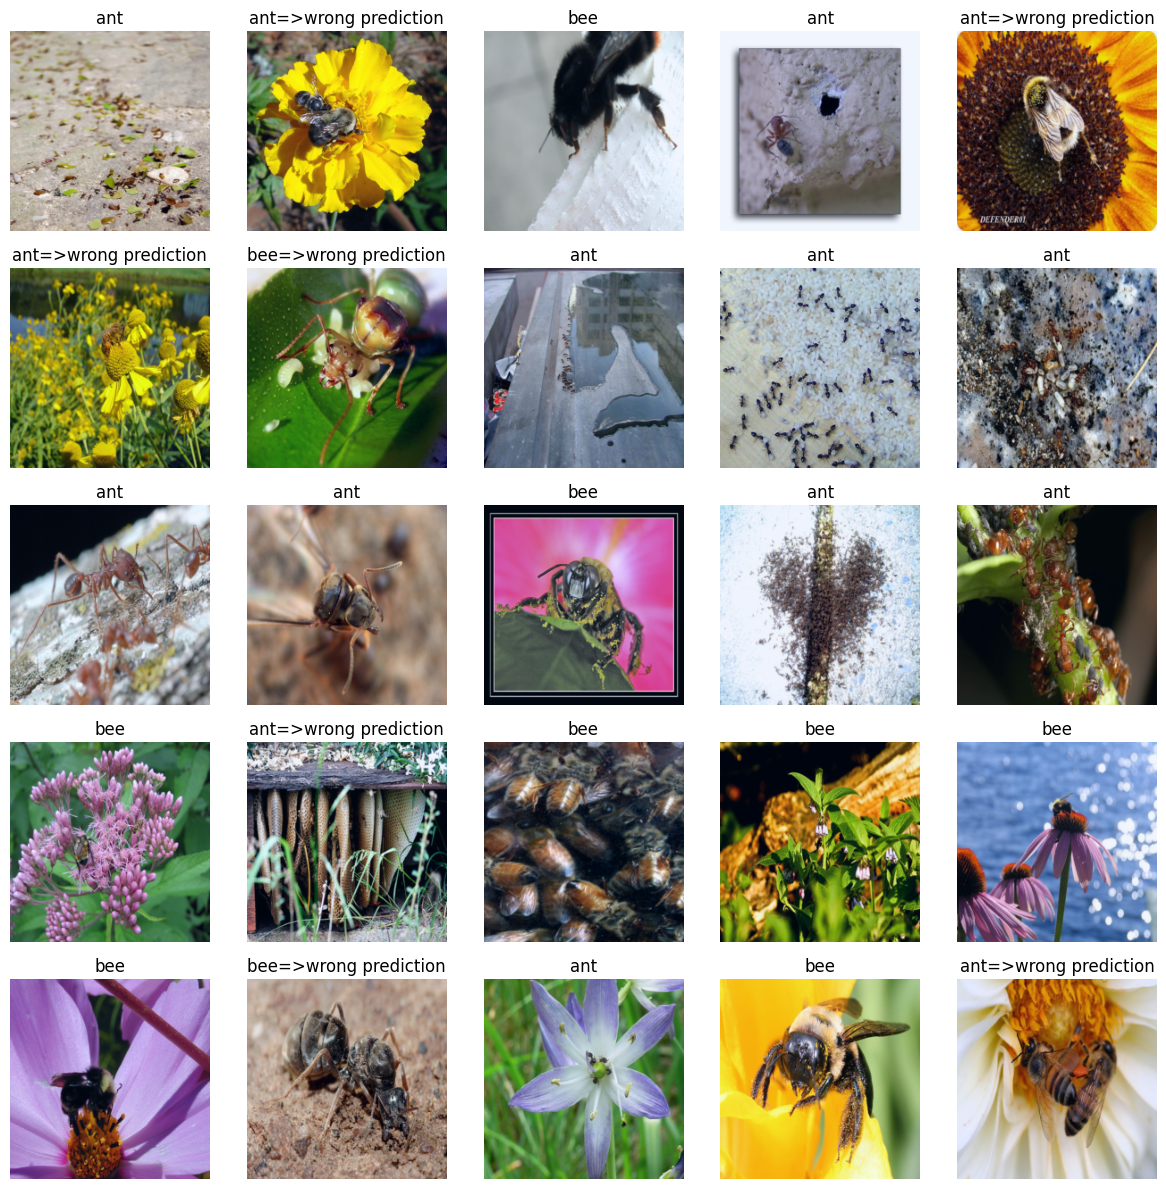

In [35]:
import matplotlib.pyplot as plt
from random import randint as rd

inv_mean = [-0.485, -0.456, -0.406]
inv_std =  [1/229, 1/224, 1/225]
inv_norm = T.Compose([T.Normalize(mean = inv_mean, std = inv_std)])

fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.flatten()
model_dir = "best_model_dir"
resnet1 = timm.create_model(model_name = "resnet18", pretrained =False , num_classes = 2)
state_dict = torch.load(f"{model_dir}/best_model.pt", weights_only=True)
resnet1.load_state_dict(state_dict)
resnet1.to(device)

for i in range(25):
    idx = rd(0, len(test_dl)-1)
    t_batch = test_dl.dataset[idx]
    pics, gts = t_batch
    pics = pics.to(device)
    preds = resnet1(pics.unsqueeze(0))
    bashorat = preds.argmax(dim = 1).item()
    javob = gts
    if bashorat == javob:
        nom = "bee" if bashorat == 1 else "ant"
    else:
        nom = "bee" if bashorat == 1 else "ant"
        nom = f"{nom}=>wrong prediction"


    pic = pics.cpu().squeeze(0)
    pic = inv_norm(pic)
    image = pic.permute(1, 2, 0)

    image = (image - image.min()) / (image.max() - image.min())
    axes[i].imshow(image)
    axes[i].set_title(f"{nom}")
    axes[i].axis("off")
plt.tight_layout()